# Layer Fidelity for Placement

Use layer fidelity runs on a device to get an updated error map that can be used for placement using VF2 and other tools. Here we give an example based on running two sets of grid chains across the device (*Grids*). At the end we include an example for how to use this to find the best N qubit chain on a device.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import rustworkx as rx
import pandas as pd
import datetime

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_experiments.framework.experiment_data import ExperimentData
from qiskit_experiments.library.randomized_benchmarking import LayerFidelity
from qiskit_device_benchmarking.utilities.gate_map import plot_gate_map
from qiskit.transpiler import CouplingMap

import qiskit_device_benchmarking.utilities.graph_utils as gu
import qiskit_device_benchmarking.utilities.layer_fidelity_utils as lfu

## Get Backend

In [2]:
# load service
service = QiskitRuntimeService()

In [12]:
# Specify machine
machine = 'ibm_fez'
hgp = ''

# Get backend 
backend = service.backend(machine, instance=hgp)
coupling_map = backend.coupling_map

# Get two qubit gate
if "ecr" in backend.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend.configuration().basis_gates:
    twoq_gate = "cz"
else:
    twoq_gate = 'cx'

# Get one qubit basis gates
oneq_gates = []
for i in backend.configuration().basis_gates:
    #put in a case to handle rx and rzz
    if i.casefold()=='rx' or i.casefold()=='rzz':
        continue
    if i.casefold()!=twoq_gate.casefold():
            oneq_gates.append(i)


## Grids

In [13]:
#first get the grid chains, these are hard coded in the layer fidelity utilities module
grid_chains = lfu.get_grids(backend)

#there are two sets of chains that can be run in four disjoint experiments
print('Decomposing grid chain into disjoint layers')
layers = [[] for i in range(4)]
grid_chain_flt = [[],[]]
for i in range(2):
    all_pairs = gu.path_to_edges(grid_chains[i], coupling_map)
    for j, pair_lst in enumerate(all_pairs):
        grid_chain_flt[i] += grid_chains[i][j]
        sub_pairs = [tuple(pair) for pair in pair_lst] # make this is a list of tuples
        layers[2*i] += sub_pairs[0::2]
        layers[2*i+1] += sub_pairs[1::2]

# Check that each list is in the coupling map and is disjoint
for layer in layers:
    for qpair in layer:
        if tuple(qpair) not in coupling_map:
            raise ValueError(f"Gate on {qpair} does not exist")

        for k in layer:
            if k == qpair:
                continue

            if k[0] in qpair or k[1] in qpair:
                print(f'Warning: sets are not disjoint for gate {k} and {qpair}')
print('Disjoint layer 1')
print(layers[0])
print('Disjoint layer 2')
print(layers[1])
print('Disjoint layer 3')
print(layers[2])
print('Disjoint layer 4')
print(layers[3])

Decomposing grid chain into disjoint layers
Disjoint layer 1
[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15), (19, 35), (34, 33), (32, 31), (30, 29), (28, 27), (26, 25), (24, 23), (22, 21), (40, 41), (42, 43), (44, 45), (46, 47), (48, 49), (50, 51), (52, 53), (54, 55), (59, 75), (74, 73), (72, 71), (70, 69), (68, 67), (66, 65), (64, 63), (62, 61), (80, 81), (82, 83), (84, 85), (86, 87), (88, 89), (90, 91), (92, 93), (94, 95), (99, 115), (114, 113), (112, 111), (110, 109), (108, 107), (106, 105), (104, 103), (102, 101), (120, 121), (122, 123), (124, 125), (126, 127), (128, 129), (130, 131), (132, 133), (134, 135), (139, 155), (154, 153), (152, 151), (150, 149), (148, 147), (146, 145), (144, 143), (142, 141)]
Disjoint layer 2
[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 19), (35, 34), (33, 32), (31, 30), (29, 28), (27, 26), (25, 24), (23, 22), (21, 20), (41, 42), (43, 44), (45, 46), (47, 48), (49, 50), (51, 52), (53, 54), (55, 59), (75, 74), (7

In [14]:
#generate two experiments
lfexps = []
for i in range(2):
    lfexps.append(LayerFidelity(
        physical_qubits=grid_chain_flt[i],
        two_qubit_layers=layers[2*i:(2*i+2)],
        lengths=[1, 10, 20, 30, 40, 60, 80, 100, 150, 200, 400],
        backend=backend,
        num_samples=6,
        seed=60,
        two_qubit_gate=twoq_gate,
        one_qubit_basis_gates=oneq_gates,
    ))

    # set maximum number of circuits per job to avoid errors due to too large payload
    lfexps[i].experiment_options.max_circuits = 144


In [15]:
%%time
#run
# number of shots per job

#if you want to run this through the sampler with gen3-turbo
#uncomment below and in run use `sampler=sampler2`
#from qiskit_ibm_runtime import SamplerV2 as Sampler
#sampler2 = Sampler(backend_real)
#sampler2.options.experimental = {"execution_path": "gen3-turbo"}
#sampler2.options.default_shots = 300

nshots = 200

# Run the LF experiment (generate circuits and submit the job)
exp_data_lst = []
for i in range(2):
    exp_data_lst.append(lfexps[i].run(shots=nshots))
    print(f"Run experiment: ID={exp_data_lst[i].experiment_id} with jobs {exp_data_lst[i].job_ids}]")

Run experiment: ID=8108132a-ec61-4507-8c92-b5b4c37d1156 with jobs ['cx5pasvrkac00085t1w0']]
Run experiment: ID=9cc3f46a-37be-4d57-9e8b-ba39f47ffe0b with jobs ['cx5pbb5tpsjg008vd08g']]
CPU times: user 1min 38s, sys: 3.45 s, total: 1min 41s
Wall time: 2min 18s


In [7]:
#make an updated error map
updated_err_dicts = []
err_dict = lfu.make_error_dict(backend, twoq_gate)

for i in range(2):
    #get the results from the experiment
    df = exp_data_lst[i].analysis_results(dataframe=True)
    for j in range(2):
        updated_err_dicts.append(lfu.df_to_error_dict(df,layers[2*i+j]))


err_dict = lfu.update_error_dict(err_dict, updated_err_dicts)


Text(0.5, 1.0, 'Gate Errors for ibm_rensselaer, Measured using Layer Fidelity vs Reported')

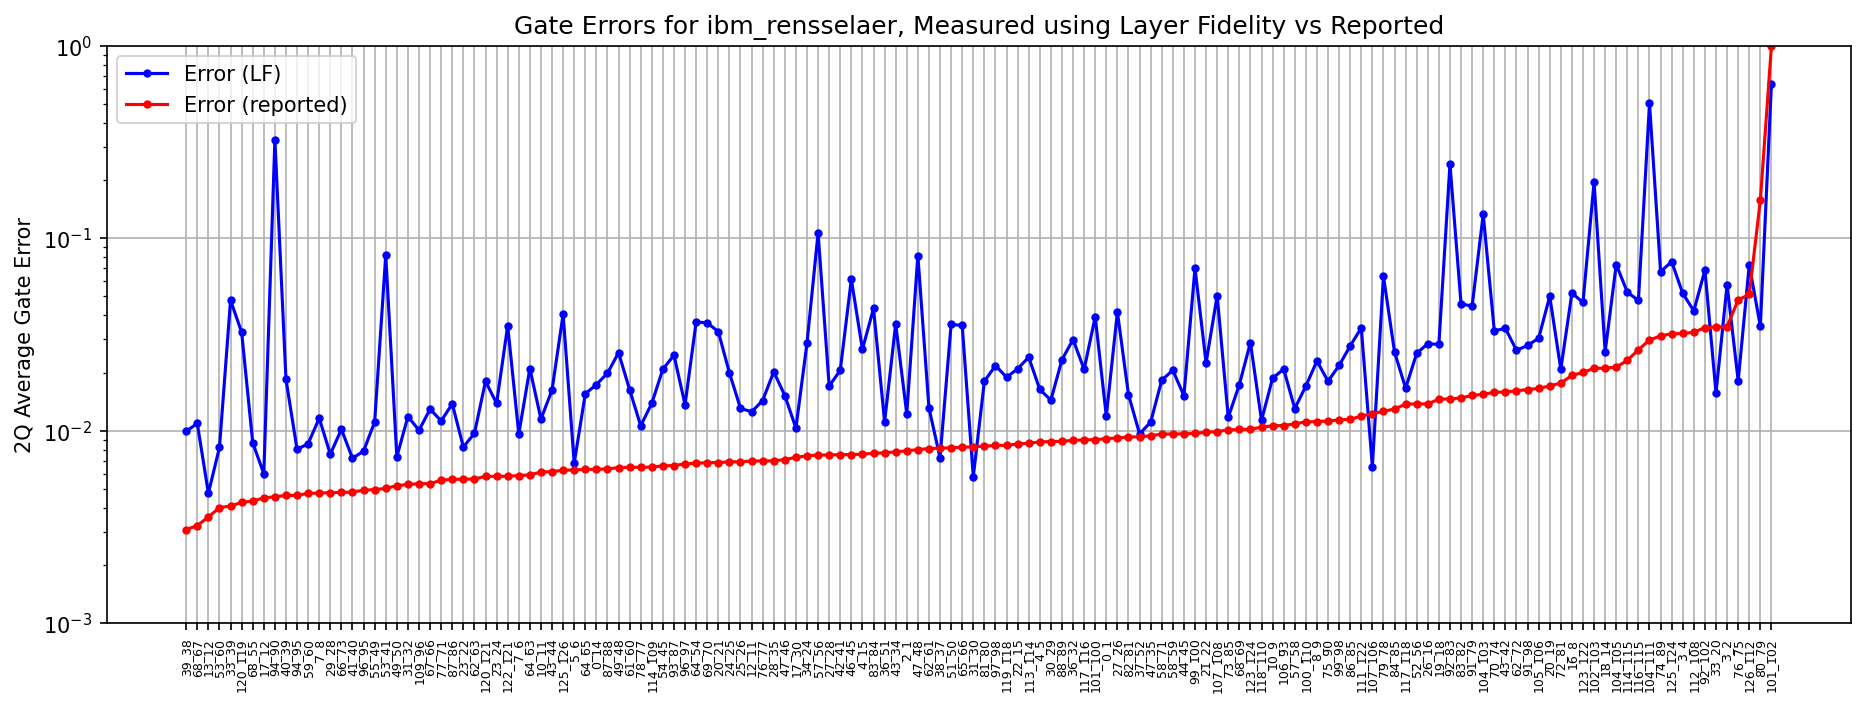

In [9]:
#compare the device reported data map to the data map from the LF runs
err_dict_orig = lfu.make_error_dict(backend, twoq_gate)

err_list = [err_dict[i] for i in err_dict]
err_lbl_list = [i for i in err_dict]
err_list_org = [err_dict_orig[i] for i in err_lbl_list]

plt.figure(dpi=150,figsize=[15,5])
argind = np.argsort(err_list_org)
plt.semilogy(range(len(err_list)),np.array(err_list)[argind],label='Error (LF)', color='blue', marker='.')
plt.semilogy(range(len(err_list)),np.array(err_list_org)[argind],label='Error (reported)', color='red', marker='.')

plt.xticks(range(len(err_lbl_list)),np.array(err_lbl_list)[argind],rotation=90,fontsize=6);
plt.ylabel('2Q Average Gate Error')
plt.ylim([1e-3,1])
plt.grid(True)
plt.legend()
plt.title('Gate Errors for %s, Measured using Layer Fidelity vs Reported'%(backend.name))

In [ ]:
# Plot 1Q/2Q simultaneous direct RB curves
for i in range(0,10):
    display(exp_data_lst[0].figure(i))

## Example Layer Finding

Take the error dictionary generated from the above code and find the best length N chain from a heuristic algorithm. 

The error dictionary can be used in any layout code.

In [10]:
#compute the set layer fidelity for a set
def layer_fid_chain(error_dict, chain):

    """
    Take in a error dictionary and chain and calculate layer fid

    Args:
        error_dict: a dictionary of gate pairs and errors {'1_2': 0.001, '3_5': 0.02} and/or
        single qubit and errors {'1': 0.001}
        chain: 1D chain of qubits
    Returns:
        layer fidelity (depolarizing approx)
    """

    fid_layer = 1

    for qind,q in enumerate(chain):

        #treat the beginning and end differently
        if qind==0 or qind==(len(chain)-1):

            if '%d'%q in error_dict:
                fp = 1 - 3/2*error_dict['%d'%q]
                fid_layer *= fp

        if qind==(len(chain)-1):
            continue

        if '%d_%d'%(q,chain[qind+1]) in error_dict:
            key_ind = '%d_%d'%(q,chain[qind+1])
        else:
            key_ind = '%d_%d'%(chain[qind+1],q)

        #simple gamma calc for depolarizing errors
        fp = 1 - ((2**(2)+1)/2**(2))*error_dict[key_ind]

        fid_layer *= fp

    return fid_layer

In [11]:
%%time

#Warning: this can be very time consuming if the wrong settings are used
#Length 100 chain on eagle, with fid_cutoff=0.95 should take about a minute

#length of path to find
path_len = 100
#initial guess at best fidelity
best_fid = [0.0]
#fidelity cutoff
#this rejects paths that don't seem to be better than fid_cutoff*best_fid
#If this is set to 0, ALL paths will be found, but this is very time consuming
#If this is set to, e.g., 0.99, then it will heuristically restrict the paths
#and the time will shorter but not guaranteed to find the best path
fid_cutoff = 0.99

#calculate all the gammas from the reported gate errors
len_sets_fid = []
len_sets_all = []

#create this graph dictionary of each qubit and it's neighbors
graph_dict = gu.create_graph_dict(coupling_map, backend.num_qubits)

for j in range(backend.num_qubits):
    start_q = j
    len_sets = gu.iter_neighbors(graph_dict,start_q,err_dict,
                               best_fid,fid_cutoff,[start_q],1.,path_len)

    for i in range(len(len_sets)):
        len_sets[i].reverse
        if len_sets[i] in len_sets_all:
            continue
        len_sets_all.append(len_sets[i])
        len_sets_fid.append(layer_fid_chain(err_dict,len_sets[i]))

print('%d length %d chains found'%(len(len_sets_all), path_len))

ind_sort = np.argsort(len_sets_fid)
print('Best Chain: %s \nFidelity: %f'%(len_sets_all[ind_sort[-1]], len_sets_fid[ind_sort[-1]]))


17 length 100 chains found
Best Chain: [56, 52, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 35, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 55, 68, 69, 70, 74, 89, 88, 87, 93, 106, 107, 108, 112, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 109, 96, 97, 98, 91, 79, 80, 81, 82, 83, 84, 85, 73, 66, 65, 64, 63, 62, 61, 60, 59, 58, 71, 77, 76, 75, 90] 
Fidelity: 0.049579
CPU times: user 11.9 s, sys: 7.43 ms, total: 11.9 s
Wall time: 11.9 s


# Copyright

In [5]:
import datetime
from IPython.display import HTML, display

def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))

qiskit_copyright()